In [1]:
import torchio as tio
import os
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import image_augmentation_util

In [2]:
source_mask_dir = "../assets/wm_gm_csf_masks"
source_data_dir = "../assets/source_images"

In [3]:
len(os.listdir(source_data_dir)), len(os.listdir(source_mask_dir))

(359, 359)

In [4]:
augmented_source_dir = "../assets/augmented_source_images"

In [5]:
destination_data_dir = "../assets/cc_motion_corrupted"

In [7]:
os.makedirs(augmented_source_dir, exist_ok=True)
os.makedirs(destination_data_dir, exist_ok=True)

In [8]:
motion_transformation = tio.transforms.RandomMotion(
    degrees=5,
    translation=10,
    num_transforms=3
)

In [9]:
output_shape = (256, 288, 288)

crop_or_pad = tio.CropOrPad(output_shape)

In [10]:
source_images = os.listdir(source_data_dir)

In [11]:
def normalize_image_0_255(image, min_max=True):
    image_array = image.get_fdata()

    min_val = np.min(image_array)
    max_val = np.max(image_array)

    print(f"before normalization: {max_val}")

    if min_max:
        image_array = ((image_array - min_val) / (max_val - min_val))
    else:
        image_array = image_array / 255

    print(f"after normalization: {np.max(image_array)}")

    normalized_image = nib.Nifti1Image(image_array, image.affine)

    return normalized_image

In [12]:
def apply_mask(image, mask):
    image_array = image.get_fdata()
    mask_array = mask.get_fdata()

    mask_array = mask_array.astype(bool)

    masked_image_array = image_array * mask_array

    masked_image = nib.Nifti1Image(masked_image_array, image.affine)

    return masked_image

In [13]:
def apply_contrast_inversion(image, mask):
  image_array = image.get_fdata()
  mask_array = mask.get_fdata()
      
  threshold = np.max(mask_array)

  binary_mask = mask_array == threshold

  max_intensity = np.max(image_array[binary_mask])

  inversed_image_array = image_array.copy()
  inversed_image_array[binary_mask] = max_intensity - image_array[binary_mask]

  print(inversed_image_array[:, :, 170][40, 150])

  inversed_image_array = (inversed_image_array - np.min(inversed_image_array)) / (np.max(inversed_image_array) - np.min(inversed_image_array))

  inversed_image_array = (inversed_image_array * 255).astype(np.uint8)

  inversed_image = nib.Nifti1Image(inversed_image_array, image.affine)

  return inversed_image

In [13]:
import time
from tqdm import tqdm

for image in tqdm(source_images, total=len(source_images)):
    print(f"Now processing: {image}")

    if image == ".DS_Store" or image == "CC0237_siemens_3_59_F.nii":
        continue
    
    start = time.time()

    three_d_image = nib.load(os.path.join(source_data_dir, image))
    image_mask = nib.load(os.path.join(source_mask_dir, image.split(".")[0] + ".nii"))

    three_d_image = normalize_image_0_255(three_d_image)

    three_d_image = apply_mask(three_d_image, image_mask)

    # three_d_image = apply_contrast_inversion(three_d_image, image_mask)

    three_d_image = crop_or_pad(three_d_image)

    transformed_image = motion_transformation(three_d_image)
    # transformed_image = image_augmentation_util.motion_corrupt_3d(three_d_image, thresh_translation=10, thresh_rotation_angle=5)

    transformed_image = normalize_image_0_255(transformed_image, min_max=False)

    nib.save(three_d_image, os.path.join(augmented_source_dir, image))
    nib.save(transformed_image, os.path.join(destination_data_dir, image))

    # testing code
    # transformed_image_array = transformed_image.get_fdata()
    # print(f"The pixel value is: {transformed_image_array[:, :, 130][40, 150]}")
    # print(f"Max: {transformed_image_array[:, :, 130].max()}")
    # print(f"Min: {transformed_image_array[:, :, 130].min()}")

    # plt.imshow(three_d_image.get_fdata()[:, :, 150], cmap="gray", vmin=0, vmax=1)

    print(f"Time taken: {time.time() - start}")

  0%|          | 0/359 [00:00<?, ?it/s]

Now processing: CC0001_philips_15_55_M.nii
before normalization: 3030.7017822265625
after normalization: 1.0


  0%|          | 1/359 [00:02<12:13,  2.05s/it]

Time taken: 2.049187183380127
Now processing: CC0002_philips_15_56_M.nii
before normalization: 3258.320903778076
after normalization: 1.0


  1%|          | 2/359 [00:04<13:58,  2.35s/it]

Time taken: 2.5573225021362305
Now processing: CC0003_philips_15_63_F.nii
before normalization: 2750.294593811035
after normalization: 1.0


: 

In [18]:
test_slice = nib.load("../assets/cc_motion_corrupted/CC0001_philips_15_55_M.nii")

In [10]:
# test_slice = normalize_image_0_255(test_slice)

In [19]:
test_slice = test_slice.get_fdata()

In [16]:
test_slice[:, :, 130].max()

0.432523250579834

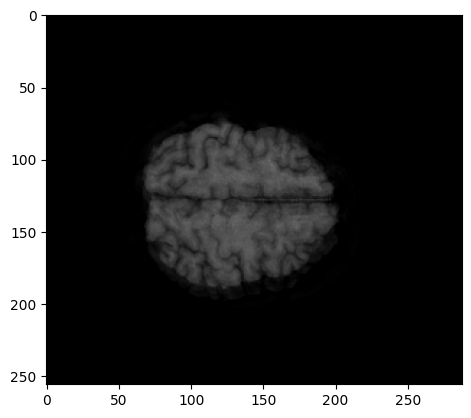

In [31]:
plt.imshow(test_slice[:, :, 180], cmap="gray", vmin=0, vmax=1)

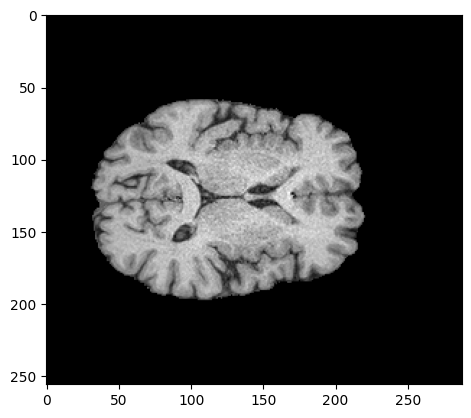

In [27]:
plt.imshow(test_slice[:, :, 150], cmap="gray")

In [22]:
nib.load(destination_data_dir + "/" +os.listdir(augmented_source_dir)[120]).get_fdata().shape

(256, 288, 288)

In [7]:
from PIL import Image

In [6]:
# test_slice = Image.open("../assets/source_images_train" + "/" + "2d_slices" + "/" + "CC0001_philips_15_55_M_slice_117.png").convert("L")
test_slice = plt.imread("../assets/source_images_train" + "/" + "2d_slices" + "/" + "CC0001_philips_15_55_M_slice_117.png")

In [61]:
test_slice = np.array(test_slice)

In [62]:
test_slice[100, 100]

array([0.24313726, 0.24313726, 0.24313726, 1.        ], dtype=float32)

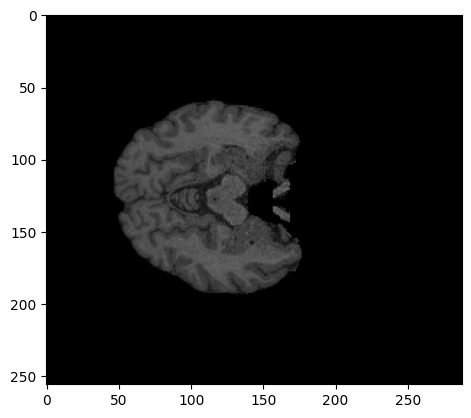

In [56]:
plt.imshow(test_slice, cmap="gray", vmin=0, vmax=255)

In [57]:
test_slice = (test_slice) / 255

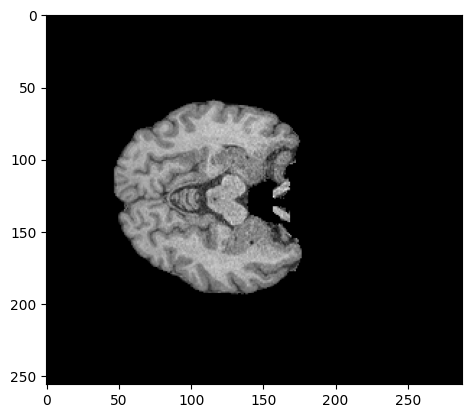

In [59]:
plt.imshow(test_slice, cmap="gray")